In [1]:
# Import essential libraries for data manipulation
import pandas as pd
import numpy as np

# Load the cleaned Airbnb dataset from the processed data folder
df = pd.read_csv("../data/processed/airbnb_cleaned.csv")

# Display first few rows to understand structure
df.head()

,host id,host_identity_verified,neighbourhood group,neighbourhood,lat,long,country,country code,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
0,80014485718,unconfirmed,Brooklyn,Kensington,40.64749,-73.97237,United States,US,False,strict,Private room,2020.0,966.0,193.0,10.0,9.0,0.21,4.0,6.0,286.0
1,52335172823,verified,Manhattan,Midtown,40.75362,-73.98377,United States,US,False,moderate,Entire home/apt,2007.0,142.0,28.0,30.0,45.0,0.38,4.0,2.0,228.0
2,85098326012,unconfirmed,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,US,True,moderate,Entire home/apt,2005.0,368.0,74.0,30.0,270.0,4.64,4.0,1.0,322.0
3,92037596077,verified,Manhattan,East Harlem,40.79851,-73.94399,United States,US,False,moderate,Entire home/apt,2009.0,204.0,41.0,10.0,9.0,0.10,3.0,1.0,289.0
4,45498551794,verified,Manhattan,Murray Hill,40.74767,-73.97500,United States,US,True,flexible,Entire home/apt,2013.0,577.0,115.0,3.0,74.0,0.59,3.0,1.0,374.0


In [2]:
# Create an estimated revenue column
# Revenue ≈ price × availability_365
df["revenue_estimate"] = df["price"] * df["availability 365"]

In [3]:
# Calculate median revenue to split dataset into two equal groups
median_revenue = df["revenue_estimate"].median()

# Create binary target column:
# 1 → High revenue listing
# 0 → Low revenue listing
df["high_revenue"] = (df["revenue_estimate"] > median_revenue).astype(int)

# Check distribution (for verification only)
df["high_revenue"].value_counts()

high_revenue
0    34743
1    34734
Name: count, dtype: int64

In [4]:
# Select numerical features relevant for market segmentation
features = df[["price", "number of reviews", "availability 365"]]

In [5]:
# Import StandardScaler to normalize features
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit and transform features
scaled_features = scaler.fit_transform(features)

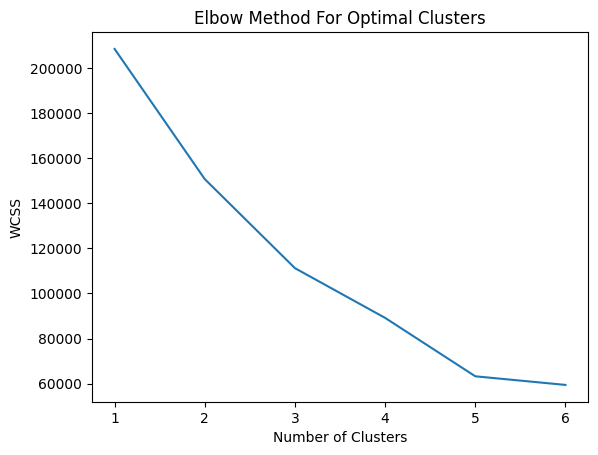

In [6]:
# Import KMeans and matplotlib
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Store Within-Cluster Sum of Squares (WCSS)
wcss = []

# Test cluster sizes from 1 to 6
for i in range(1, 7):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot Elbow graph
plt.figure()
plt.plot(range(1, 7), wcss)
plt.title("Elbow Method For Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

In [7]:
from sklearn.cluster import KMeans

# Create KMeans model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit model on scaled features
kmeans.fit(scaled_features)

# Assign cluster labels to dataframe
df["cluster"] = kmeans.labels_

df["cluster"].value_counts()

cluster
0    38462
2    24558
1     6457
Name: count, dtype: int64

In [8]:
# Calculate average values per cluster
cluster_summary = df.groupby("cluster")[["price", 
                                         "number of reviews", 
                                         "availability 365", 
                                         "revenue_estimate"]].mean()

cluster_summary

,price,number of reviews,availability 365,revenue_estimate
cluster,,,,
0,527.175550,17.760777,40.983698,21652.506344
1,528.824686,161.094626,174.682050,93150.902741
2,520.296604,20.742121,290.505742,151541.603591


In [9]:
# Preparing the Data for Logistic Regression

from sklearn.model_selection import train_test_split

# Selecting feature variables
X = df[["price", 
        "number of reviews", 
        "availability 365", 
        "cluster"]]

# Target variable (what we want to predict)
y = df["high_revenue"]

# Splitting data into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

X_train.shape

(55581, 4)

In [10]:
# Training the Logistic Regression Model


from sklearn.linear_model import LogisticRegression

# Create the model
log_model = LogisticRegression(max_iter=1000)

# Train the model using training data
log_model.fit(X_train, y_train)

# Predict on test data
y_pred = log_model.predict(X_test)

y_pred[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [11]:
# Evaluating the Logistic Regression Model


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate classification report
class_report = classification_report(y_test, y_pred)

accuracy, conf_matrix, class_report

(0.9209124928036845,
 array([[6444,  432],
        [ 667, 6353]]),
 '              precision    recall  f1-score   support\n\n           0       0.91      0.94      0.92      6876\n           1       0.94      0.90      0.92      7020\n\n    accuracy                           0.92     13896\n   macro avg       0.92      0.92      0.92     13896\nweighted avg       0.92      0.92      0.92     13896\n')

In [12]:
# =====================================================
# Final Conclusion
# =====================================================

# 1. K-Means clustering divided listings into 3 clear segments 
#    based on price, number of reviews, availability, and revenue.

# 2. The analysis shows that availability and number of reviews 
#    are the strongest drivers of revenue.

# 3. Price does not significantly impact revenue, as average prices 
#    were nearly identical across all clusters.

# 4. Listings with higher availability (more days open per year) 
#    generated the highest revenue.

# 5. Listings with a high number of reviews showed strong and 
#    consistent performance, indicating trust and demand matter.

# 6. Logistic Regression achieved 92% accuracy in predicting 
#    whether a listing will generate high revenue or not.

# 7. The model is well-balanced, with strong precision and recall, 
#    meaning it reliably identifies both high and low revenue listings.

# Final Business Insight:
# Increasing availability and improving customer reviews are 
# more effective strategies for revenue growth than adjusting price alone.